# 1 Data Preprocessing
---------
##    1 Choose Sensor: 
###        1 ALL unique
###        2 integration
* SoundWall, SoundCenter, ... -> "Sound"
* Seat1, Seat2, ... -> "Seat"
##    2 Choose Values: 
###        1 Raw
####            1 Continuous Values
* Sound: 50-100 db
* Temperature, Humidity, Brightness
####            2 Discrete Values
* Motion, Door: ON/OFF, OUT/IN
###        2 pick the values considering "threshold"


In [1]:
import numpy as np
import time
from feature import extract_feature_testbed as eft
from feature import normalize_feature as nf
from densityratio import Densratio
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [2]:
"""load data"""
data_folder="../date_activity/integrate"
npy_files=[
# '180709_174940_C.npy',#: (512, 3)
# '170621_200415_D.npy',#: (513, 3)
# '180122_190000_P.npy',#: (514, 3)
# '180513_184606_G.npy'#: (517, 3)
# '180212_145745_C.npy', #(405, 3)
# '180515_131702_G.npy', #(412, 3)
# '180405_165701_D.npy', #(426, 3)
# '180813_095830_P.npy', #(460, 3)
# '180418_130100_D.npy',#: (389, 3)
# '180512_211802_C.npy',#: (404, 3)
# '180529_150020_C.npy',#: (405, 3)
# '180831_102801_C.npy',#: (407, 3)
# '180508_160402_G.npy',#: (428, 3)
# '180515_192400_P.npy',#: (434, 3)
# '180813_095830_P.npy' #(175, 3)
'180518_145501_C.npy',#: (326, 3)
'180813_095830_P.npy',#: (333, 3)
'180721_103311_D.npy',#: (690, 3)
'180419_144100_G.npy',#: (909, 3)

]
task_order=[]
for item in npy_files:
    task_order.append(np.load("{}/{}".format(data_folder, item)))

# g=np.load("../date_activity/integrate/180516_161050_G.npy")
# c=np.load("../date_activity/integrate/180713_155855_C.npy")
# d=np.load("../date_activity/integrate/180330_142201_D.npy")
# p=np.load("../date_activity/integrate/180530_102731_P.npy")

# task_order=[g,c,d,p]
merged=np.concatenate(tuple(task_order), axis=0)
atd=[] # end of each activity
idx=-1
for item in task_order:
    idx+=item.shape[0]
    atd.append(idx)



# 2 Feature Extraction
---------
##    1 Sliding Window Size: 30 (default, paper)
##    2 Choose Features:
* Temporal
* Window
* Sensor
##    3 View Size: 2 (default, 2-real-time algorithm)
###           1 [t-1, t] and [t, t+1] (NO)
###           2 [t, t+1] and [t+1, t+2] (NO)
###           3 [t-1, t] and [t+1, t+2]
###           4 [t-2, t-1] and [t+1, t+2]!

In [3]:
"""sliding window"""
ws=30
windows=[]
for i in range(merged.shape[0]):
    single_window=merged[i-ws+1:i+1,:]
    if i+1<ws:
        repeat=np.array([merged[0,:] for j in range(ws-i-1)])
        single_window=np.concatenate((repeat,merged[:i+1]), axis=0)
    windows.append(single_window)
windows=np.array(windows)
# print(merged.shape, windows.shape)
# print(windows[29])

In [4]:
"""feature extraction"""
sensor_set=set(merged[:,0])
features=np.array([eft(windows[i], sensor_set) for i in range(windows.shape[0])])

In [5]:
"""view"""
vs=2
views=[]
for i in range(features.shape[0]):
    if i<=1:
        nu_l, nu_r=features[0,:], features[0,:]
    else:
        nu_l=features[i-2]; nu_r=features[i-1]
    if i>=features.shape[0]-2:
        de_l, de_r=features[-1,:], features[-1,:]
    else:
        de_l=features[i+1]; de_r=features[i+2]
    
    views.append([[nu_l, nu_r], [de_l, de_r]])
views=np.array(views)
views.shape

(2258, 2, 2, 15)

# 3 Change Point Detection
---------
## algorithm: SEP (default, paper)


In [6]:
scores=[]
start=time.time()
score_file='scores_3.npy'
for i in range(views.shape[0]):
    if i%500==0:
        print("{}/{}: elapsed time: {}s".format(i, views.shape[0]-1, time.time()-start))
        np.save(score_file, scores)
    # norm_view, col_norms=nf(views[i], 4)
    # norm_view=norm_view.reshape((2,2,-1))*col_norms.max()
    # v_b, v_a=norm_view[0], norm_view[1]
    v_b, v_a=views[i][0], views[i][1]
    scores.append(Densratio(x=v_b, y=v_a).SEPDiv)
scores=np.array(scores)
np.save(score_file, scores)

0/2257: elapsed time: 0.00017309188842773438s
500/2257: elapsed time: 563.0774958133698s
1000/2257: elapsed time: 1122.7860281467438s
1500/2257: elapsed time: 1680.2701115608215s
2000/2257: elapsed time: 2240.2074959278107s




# 4 Evaluation
---------
## threshold: 0.3 (default)
## local peak value 

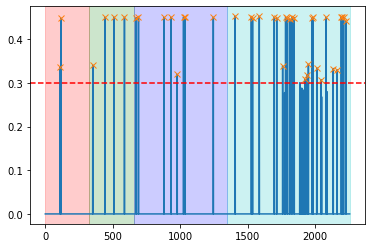

In [6]:
scores=np.load("scores_3.npy")
threshold=0.3
# final=np.where(scores<threshold, 0, scores)
final=scores
# plt.plot(range(len(final)), final)
peaks, _=find_peaks(final)

test=[]         
for item in peaks:
    if scores[item]>threshold:
        test.append(item)
# test=np.where(np.any(scores[peaks]>threshold))
plt.plot(range(len(final)), final)
plt.axhline(y=threshold,linestyle='--',color='r')
plt.plot(test, final[test], 'x')

clr='rgbc'
for i, item in enumerate(atd):
    if not i:
        plt.axvspan(0, atd[i], alpha=0.2, color=clr[i])
    else:
        plt.axvspan(atd[i-1], atd[i], alpha=0.2, color=clr[i])
# plt.legend()

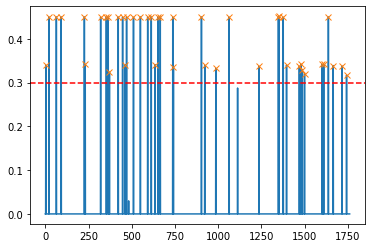

In [18]:
scores__=np.load("scores_removeAC_PE_SEOFF_separate.npy")
threshold=0.3
# final=np.where(scores<threshold, 0, scores)
final=scores__
# plt.plot(range(len(final)), final)
peaks, _=find_peaks(final)

test=[]
for item in peaks:
    if scores__[item]>threshold:
        test.append(item)
# test=np.where(np.any(scores[peaks]>threshold))
plt.plot(range(len(final)), final)
plt.axhline(y=threshold,linestyle='--',color='r')
plt.plot(test, final[test], 'x')

In [51]:
print(test)
print(atd)

[111, 115, 352, 442, 509, 587, 674, 691, 880, 933, 978, 1025, 1037, 1246, 1408, 1528, 1537, 1587, 1698, 1716, 1760, 1782, 1796, 1813, 1829, 1846, 1924, 1941, 1951, 1979, 1986, 2013, 2045, 2083, 2135, 2164, 2195, 2203, 2212, 2230]
[325, 658, 1348, 2257]


In [17]:
"""Analysis"""
non_idx=933

print('windows')
print(non_idx-ws-1,windows[non_idx-ws-1][-1])
for i in range(ws):
    print(non_idx-ws+i,windows[non_idx-1][i])
print('='*30)
print(non_idx,windows[non_idx][-1],'*')
print('='*30)
print(non_idx+1,windows[non_idx+1][-1])
print(non_idx+2,windows[non_idx+2][-1])
print('Original View')
print(views[non_idx].astype(int))
# view_, maxx=nf(views[non_idx], 4)
# view_=view_.reshape((2,2,-1))*maxx.max()
# print('Revised View')
# print(view_.astype(int))

# dre=Densratio(x=view_[0], y=view_[1])
dre=Densratio(x=views[non_idx][0], y=views[non_idx][1])
print('Cross-Validation:','lambda',dre.lambda_,'sigma',dre.sigma)
# print('denominator (t+1 and t+2)')
# print(dre.y.astype(int))


# print('Kernel center from numerator')
# print(dre.kernel_centers.astype(int))
print('K(center, numer)')
print(np.round(dre.phi_x,3))
print('K(center, denom)')
print(np.round(dre.phi_y,3))
print(dre.SEPDiv)
print(dre.SEPDiv_)

windows
902 ['SO' 'HIGH' '1532169861.415']
903 ['SO' 'HIGH' '1532169862.736']
904 ['SO' 'HIGH' '1532169865.324']
905 ['SO' 'HIGH' '1532169871.414']
906 ['SO' 'HIGH' '1532169872.725']
907 ['SO' 'HIGH' '1532169875.311']
908 ['SO' 'HIGH' '1532169881.404']
909 ['SO' 'HIGH' '1532169882.256']
910 ['SO' 'HIGH' '1532169882.738']
911 ['SO' 'HIGH' '1532169885.542']
912 ['SO' 'HIGH' '1532169891.415']
913 ['SO' 'HIGH' '1532169892.736']
914 ['SO' 'HIGH' '1532169895.324']
915 ['SO' 'HIGH' '1532169901.414']
916 ['SO' 'HIGH' '1532169902.725']
917 ['SO' 'HIGH' '1532169905.311']
918 ['SO' 'HIGH' '1532169911.404']
919 ['SO' 'HIGH' '1532169912.256']
920 ['SO' 'HIGH' '1532169912.738']
921 ['MT' 'ON' '1532169914.658']
922 ['SO' 'HIGH' '1532169915.554']
923 ['SO' 'HIGH' '1532169921.415']
924 ['SO' 'HIGH' '1532169922.736']
925 ['SO' 'HIGH' '1532169925.324']
926 ['SO' 'HIGH' '1532169931.414']
927 ['SO' 'HIGH' '1532169932.725']
928 ['SO' 'LOW' '1532169935.311']
929 ['SO' 'HIGH' '1532169941.404']
930 ['SO' 'HIGH

In [9]:
prev_sum=0
for j, item in enumerate(atd):
    if not j:
        denom=item+1
    else:
        denom=atd[j]-atd[j-1]
    numer=sum([1 if scores[t]>threshold and t<item else 0 for t in test])
    value=numer-prev_sum
    print(value,'/', denom)
    prev_sum=numer
    print(round(value*100/denom, 2), '%')

7 / 389
1.8 %
4 / 404
0.99 %
11 / 428
2.57 %
9 / 434
2.07 %
